# Clustering NYC Geographic Data

Explore clustering algorithms applied to New York City geographic data. We'll analyze two distinct spatial datasets that demonstrate the different strengths of K-Means and DBSCAN clustering:

1. NYC Public Schools
2. NYC Public Art

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans, DBSCAN
from sklearn.metrics import silhouette_score
import json # used to read in NYC public art dataset

## Part 1: Implementation of k-Means


### k-Means Python class

In [2]:
class KMeans:
    def __init__(self, k=5, max_iterations=100, random_state=None):

        self.k = k
        self.max_iterations = max_iterations
        self.random_state = random_state
        self.centroids = None
        self.assignments = None

    def fit(self, X):     # dataset X

        X = np.array(X)
        n_samples, n_features = X.shape

        # Initializing centroids randomly from dataset
        if self.random_state is not None:
            np.random.seed(self.random_state)
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for iteration in range(self.max_iterations):
            # Assign clusters based on closest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)  # shape: (n_samples, k)
            new_assignments = np.argmin(distances, axis=1)

            # Check if assignments do not change
            if self.assignments is not None and np.array_equal(new_assignments, self.assignments):
                print(f"Convergence reached at iteration {iteration}")
                break

            self.assignments = new_assignments

            # Update centroids as mean of assigned points
            for i in range(self.k):
                points_in_cluster = X[self.assignments == i]
                # Avoid division by zero if a cluster gets no points
                if len(points_in_cluster) > 0:
                    self.centroids[i] = np.mean(points_in_cluster, axis=0)
                else:
                    # Reinitialize centroid to a random point if it loses all points
                    self.centroids[i] = X[np.random.choice(n_samples)]


        # Returns list of cluster assignments & list of centroid coordinates
        return self.assignments.tolist(), self.centroids.tolist()

        """
        Predict the closest cluster each sample in X belongs to.
        Requires that fit() has been called already.

        - X (array-like): n x d dataset.

        - assignments (list): Cluster assignments for each instance.
        """
    def predict(self, X):
        X = np.array(X)
        distances = np.linalg.norm(X[:, np.newaxis] - np.array(self.centroids), axis=2)
        assignments = np.argmin(distances, axis=1)
        return assignments.tolist()


### **Initialization**

The centroids are initialized randomly from the dataset. `random_state` is provided for reproducibility.


### **Fit Method:**

Computes the Euclidean distance from each data point to each centroid and assigns the data point to the nearest centroid. Then it computes the new centroid as the mean of all points assigned to that cluster. If a cluster ends up empty, the centroid is reinitialized to a random data point. Finally, it stops iterations if the cluster assignments do not change.

### **Predict Method:**

After fitting, this method assigns new data points to the nearest centroid.

## Part 2: Performance Analysis of k-Means

### **Synthetic Data Tests**

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [4]:
# Generate synthetic dataset
X, true_labels = make_blobs(n_samples=700, centers=4, cluster_std=0.60, random_state=0)

### **Comparison with scikit-learn**

In [5]:
# Run k-Means implementation
kmeans_custom = KMeans(k=4, max_iterations=100, random_state=0)
custom_assignments, custom_centroids = kmeans_custom.fit(X)

Convergence reached at iteration 4


In [6]:
# Run scikit-learn's k-Means implementation
kmeans_sklearn = SKLearnKMeans(n_clusters=4, random_state=0, n_init=10)
sklearn_assignments = kmeans_sklearn.fit_predict(X)
sklearn_centroids = kmeans_sklearn.cluster_centers_

In [7]:
# Function to plot results
def plot_clusters(X, labels, centroids, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=ListedColormap(['red', 'blue', 'green', 'purple']), alpha=0.6, edgecolors='k')

    # Plot centroids only if they exist
    if len(centroids) > 0:
        centroids = np.array(centroids)
        plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', edgecolors='black', marker='X', label='Centroids')
        plt.legend()

    plt.title(title)
    plt.show()

### **Visualizations**

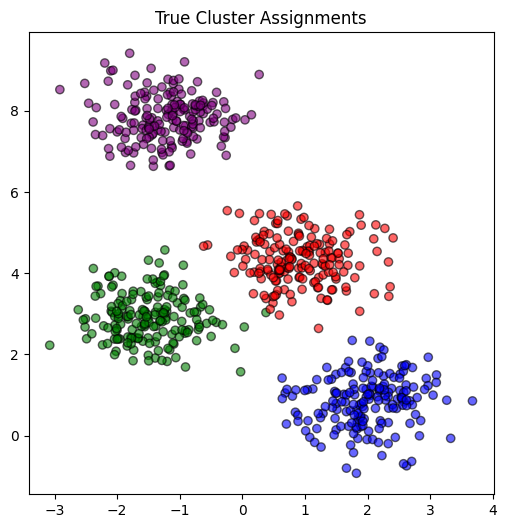

In [8]:
# Plot true clusters
plot_clusters(X, true_labels, [], "True Cluster Assignments")

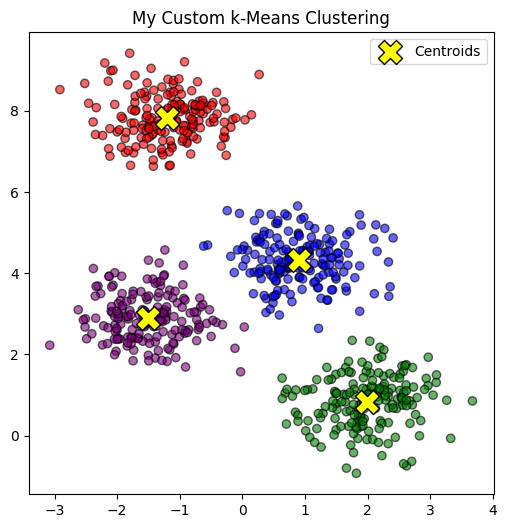

In [12]:
# Plot my k-Means results
plot_clusters(X, custom_assignments, custom_centroids, "My Custom k-Means Clustering")

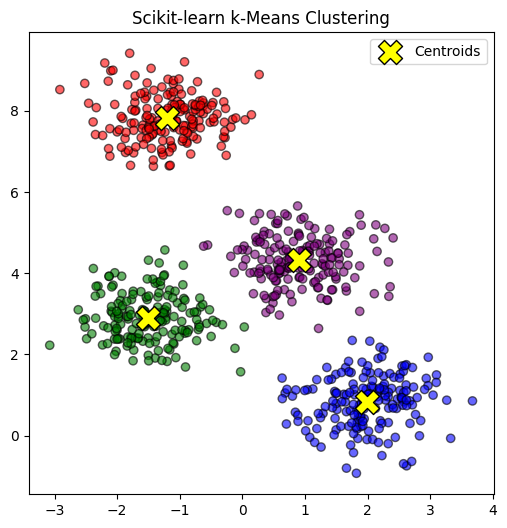

In [13]:
# Plot scikit-learn's k-Means results
plot_clusters(X, sklearn_assignments, sklearn_centroids, "Scikit-learn k-Means Clustering")

## Part 3: Dataset Clustering Analysis

### **NYC Public Schools Dataset**

### Data Loading and Preprocessing

In [14]:
# mount Google Drive
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Specify the folder
project_folder = "/content/drive/My Drive/Colab Notebooks/"

Mounted at /content/drive


In [15]:
schools_file_path = os.path.join(project_folder, "NYC-Public-Schools-Dataset.csv")

# Load NYC Public Schools dataset
schools_df = pd.read_csv(schools_file_path)

In [16]:
# dimensions of the dataframe
print(schools_df.shape)

# display the top 5 rows
schools_df.head(10)

(2190, 41)


,fiscal_year,system_code,location_code,location_name,BEDS,Managed_by_name,location_type_description,Location_Category_Description,Grades_text,Grades_final_text,...,Administrative_District_Name,community_school_sup_name,Tier_3_Support_Location_Name,Tier_3_Support_Leader_Name,Tier_2_Support_Location_Name,HighSchool_Network_Location_Code,HighSchool_Network_Name,HighSchool_Network_Superintendent,Community_district 1,Police_precinct
0,2020,15K001,K001,P.S. 001 The Bergen,331500010001,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 15,"SKOP, ANITA",NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 5- Brooklyn North,NaN,NaN,NaN,307.0,72.0
1,2020,17K002,K002,Parkside Preparatory Academy,331700010002,DOE,General Academic,Junior High-Intermediate-Middle,"06,07,08,SE","06,07,08",...,COMMUNITY SCHOOL DISTRICT 17,"ELLIS, CLARENCE",NYCDOE Borough Office - Brooklyn South,Mauriciere de Govia,School Support Team 2- Brooklyn South,NaN,NaN,NaN,309.0,71.0
2,2020,13K003,K003,P.S. 003 The Bedford Village,331300010003,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 13,"SAMUELS, KAMAR",NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 3- Brooklyn North,NaN,NaN,NaN,303.0,79.0
3,2020,75K004,K004,P.S. K004,307500013004,DOE,Special Education,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05,06,07,SE",...,CITYWIDE SPECIAL EDUCATION,"LOUISSAINT, KETLER",D75 CITYWIDE BCO,Tillman Roberto,Children First Network 752,NaN,NaN,NaN,305.0,75.0
4,2020,16K005,K005,P.S. 005 Dr. Ronald McNair,331600010005,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 16,"MARTIN, YOLANDA",NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 4- Brooklyn North,NaN,NaN,NaN,303.0,81.0
5,2020,17K006,K006,Norma Adams Clemons Academy,331700010006,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,06,SE","0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 17,"ELLIS, CLARENCE",NYCDOE Borough Office - Brooklyn South,Mauriciere de Govia,School Support Team 2- Brooklyn South,NaN,NaN,NaN,314.0,70.0
6,2020,19K007,K007,P.S. 007 Abraham Lincoln,331900010007,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 19,THOMAS MCBRYDE JR,NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 6- Brooklyn North,NaN,NaN,NaN,305.0,75.0
7,2020,13K008,K008,P.S. 008 Robert Fulton,331300010008,DOE,General Academic,K-8,"0K,01,02,03,04,05,08,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 13,"SAMUELS, KAMAR",NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 3- Brooklyn North,NaN,NaN,NaN,302.0,84.0
8,2020,13K009,K009,P.S. 009 Teunis G. Bergen,331300010009,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 13,"SAMUELS, KAMAR",NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 3- Brooklyn North,NaN,NaN,NaN,308.0,77.0
9,2020,15K010,K010,"Magnet School of Math, Science and Design Tech...",331500010010,DOE,General Academic,Elementary,"0K,01,02,03,04,05,06,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 15,"SKOP, ANITA",NYCDOE Borough Office - Brooklyn North,NaN,School Support Team 5- Brooklyn North,NaN,NaN,NaN,307.0,72.0


In [17]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   fiscal_year                        2190 non-null   int64  
 1   system_code                        2190 non-null   object 
 2   location_code                      2190 non-null   object 
 3   location_name                      2190 non-null   object 
 4   BEDS                               2190 non-null   int64  
 5   Managed_by_name                    2190 non-null   object 
 6   location_type_description          2190 non-null   object 
 7   Location_Category_Description      2190 non-null   object 
 8   Grades_text                        2103 non-null   object 
 9   Grades_final_text                  2102 non-null   object 
 10  open_date                          2190 non-null   object 
 11  Status_descriptions                2190 non-null   objec

In [18]:
schools_df.describe()

,fiscal_year,BEDS,X_COORDINATE,Y_COORDINATE,LONGITUDE,LATITUDE,Community_district,Council-district,Census_tract,Borough_block_lot,Geographical_District_code,Administrative_District_Code,Community_district 1,Police_precinct
count,2190.0,2.190000e+03,2.189000e+03,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2187.000000,2.189000e+03,2190.000000,2190.000000,2189.000000,2181.000000
mean,2020.0,3.270190e+11,1.004775e+06,208034.191868,-73.750800,40.645046,268.582458,24.159890,36540.544134,2.618429e+09,15.276712,26.266667,268.582458,64.208620
std,0.0,1.234571e+10,4.604875e+04,31647.315226,3.530418,1.947066,112.027791,14.446745,34055.675141,1.168853e+09,9.180150,25.953663,112.027791,32.490253
min,2020.0,3.075000e+11,0.000000e+00,0.000000,-74.243950,0.000000,0.000000,0.000000,13.000000,0.000000e+00,0.000000,1.000000,0.000000,1.000000
25%,2020.0,3.207009e+11,9.953920e+05,184729.000000,-73.959484,40.672710,203.000000,12.000000,13350.000000,2.025270e+09,8.000000,9.000000,203.000000,42.000000
50%,2020.0,3.313009e+11,1.006076e+06,205239.000000,-73.920851,40.729700,303.000000,23.000000,25100.000000,3.011480e+09,14.000000,18.000000,303.000000,66.000000
75%,2020.0,3.323000e+11,1.016758e+06,237567.000000,-73.881894,40.818703,317.000000,37.000000,46202.000000,3.075530e+09,23.000000,29.000000,317.000000,88.000000
max,2020.0,3.531009e+11,1.065003e+06,268380.000000,0.000000,40.903275,503.000000,51.000000,162100.000000,5.078980e+09,32.000000,84.000000,503.000000,123.000000


In [19]:
# Select only relevant columns
schools_df = schools_df[['LATITUDE', 'LONGITUDE']].dropna()

# Convert to NumPy array for clustering
school_locations = schools_df.to_numpy()

In [20]:
# Sanity check: Print min/max values to ensure they are within expected NYC range
print("Latitude range:", schools_df['LATITUDE'].min(), "to", schools_df['LATITUDE'].max())
print("Longitude range:", schools_df['LONGITUDE'].min(), "to", schools_df['LONGITUDE'].max())

Latitude range: 0.0 to 40.903275
Longitude range: -74.24395 to 0.0


In [21]:
print(schools_df[schools_df['LONGITUDE'] == 0])

      LATITUDE  LONGITUDE
1118       0.0        0.0
1399       0.0        0.0
1687       0.0        0.0
2068       0.0        0.0
2132       0.0        0.0


 Some data points have latitude = 0

 Remove Invalid Data Points

In [22]:
schools_df = schools_df[
    (schools_df["LATITUDE"] > 0) &
    (schools_df["LONGITUDE"] < 0)
]

In [23]:
print("Latitude range:", schools_df["LATITUDE"].min(), "to", schools_df["LATITUDE"].max())
print("Longitude range:", schools_df["LONGITUDE"].min(), "to", schools_df["LONGITUDE"].max())

Latitude range: 40.5083 to 40.903275
Longitude range: -74.24395 to -73.708617


In [24]:
print(schools_df.shape)

(2184, 2)


### Algorithm Selection and Implementation

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract coordinates
locations = schools_df[['LATITUDE', 'LONGITUDE']]

# Apply k-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
schools_df['Cluster'] = kmeans.fit_predict(locations)

### Results and Visualizations

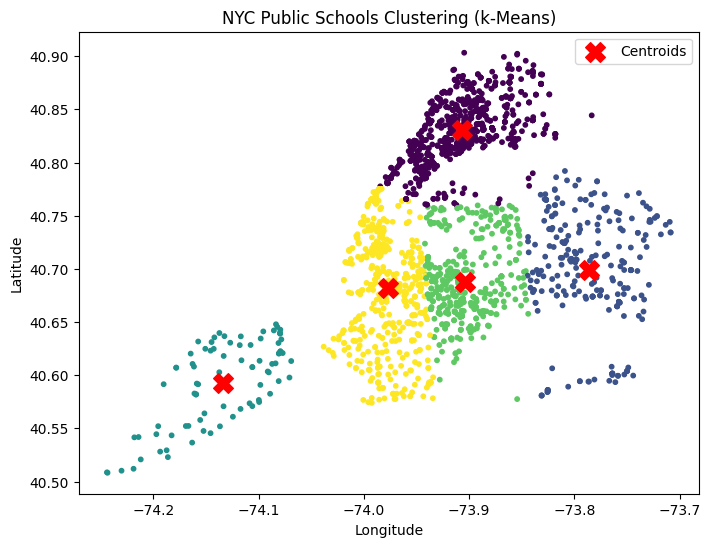

In [26]:
# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(schools_df["LONGITUDE"], schools_df["LATITUDE"], c=schools_df["Cluster"], cmap='viridis', s=10)

# Plot centroids
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='red', marker='X', s=200, label="Centroids")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("NYC Public Schools Clustering (k-Means)")
plt.legend()
plt.show()

### **NYC Public Art Dataset**

### Data Loading and Preprocessing

In [39]:
art_file_path = os.path.join(project_folder, "NYC-Public-Art-Dataset.json")

# Load NYC Public Art dataset
with open(art_file_path) as f:
    art_df = json.load(f)

In [40]:
# Convert the list of dictionaries to a Pandas DataFrame
art_df = pd.DataFrame(art_df)

In [41]:
# dimensions of the dataframe
art_df.shape

(1173, 10)

In [42]:
# display the top 10 rows
art_df.head(10)

,name,artist,from_date,to_date,location,description,borough,lat,lng,active
0,A View from the Lunch Table: Students Bringing...,LEAP,2009-05-28,2009-09-30,Various Locations,"<span style=""font-family: Verdana; font-size: ...",c,None,None,1
1,Tree Museum,Katie Holten,2009-06-21,2010-02-15,Grand Concourse,"&#8203;<span style=""font-family: Verdana; font...",X,None,None,1
2,The Ego and the Id,Franz West,2009-07-01,2010-07-16,Doris Freedman Plaza,<p><em>The Ego and the Id</em> is internationa...,M,None,None,1
3,The River that Flows Both Ways,Spencer Finch,2009-06-01,2010-06-30,None,"<font size=""3"" color=""#444444"" face=""Verdana"">...",M,None,None,1
4,A Clearing in the Streets,Julie Farris and Sarah Wayland-Smith,2009-05-22,2009-10-01,None,"<span style=""font-family: Verdana; font-size: ...",M,None,None,1
5,wall and door and roof,Richard Woods,2009-07-01,2009-09-30,None,"<span style=""font-family: Verdana; font-size: ...",M,None,None,1
6,Spotted Leaf,Richard Baronio,2009-06-02,2010-03-30,None,Richard Baronio&rsquo;s <em>Spotted Leaf</em>&...,M,None,None,1
7,Central Park Sound Tunnel,John Morton,2009-06-10,2009-09-10,None,Avant&ndash;garde composer John Morton's rich ...,M,None,None,1
8,Flooded Chambers Maid,Jessica Stockholder,2009-05-01,2009-08-15,None,<p>The <em>Flooded Chambers Maid</em> is ancho...,M,None,None,1
9,America's Chinatown Voices,Nathalie Pham & Avani Patel,2009-06-09,2009-08-08,None,<p><em>America's Chinatown Voices</em> consist...,M,None,None,1


In [43]:
# Display initial info
art_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1173 non-null   object
 1   artist       1148 non-null   object
 2   from_date    1173 non-null   object
 3   to_date      1173 non-null   object
 4   location     380 non-null    object
 5   description  1172 non-null   object
 6   borough      1173 non-null   object
 7   lat          880 non-null    object
 8   lng          880 non-null    object
 9   active       1173 non-null   object
dtypes: object(10)
memory usage: 91.8+ KB


In [44]:
# Check for missing values
print(art_df[["lat", "lng"]].isna().sum())

lat    293
lng    293
dtype: int64


In [45]:
#Convert to numeric
art_df["lat"] = pd.to_numeric(art_df["lat"], errors="coerce")
art_df["lng"] = pd.to_numeric(art_df["lng"], errors="coerce")

In [46]:
# Drop rows missing lat/lng
art_df = art_df.dropna(subset=["lat","lng"]).copy()
print("Shape after dropping missing coords:", art_df.shape)

Shape after dropping missing coords: (880, 10)


In [47]:
# Range filter for lat/lng in NYC
in_nyc_art = (
    (art_df["lat"] >= 40.0) & (art_df["lat"] <= 41.0) &
    (art_df["lng"] >= -74.5) & (art_df["lng"] <= -73.0)
)
art_df = art_df[in_nyc_art].copy()
print("shape after range filter: ", art_df.shape)

shape after range filter:  (875, 10)


### Algorithm Selection & Implementation

In [49]:
coords_art = art_df[["lat","lng"]].values
for k in [2,3,4,5]:
    km = SklearnKMeans(n_clusters=k, random_state=42)
    labs = km.fit_predict(coords_art)
    sil = silhouette_score(coords_art, labs)
    print(f"K={k}, public art silhouette={sil:.4f}")

K=2, public art silhouette=0.4268
K=3, public art silhouette=0.3861
K=4, public art silhouette=0.4990
K=5, public art silhouette=0.4322


In [50]:
km_art_4 = SklearnKMeans(n_clusters=4, random_state=42)
labels_art_4 = km_art_4.fit_predict(coords_art)
art_df["cluster_kmeans"] = labels_art_4

In [55]:
db_art = DBSCAN(eps=0.008, min_samples=5)
db_labels_art = db_art.fit_predict(coords_art)
art_df["cluster_dbscan"] = db_labels_art

n_clusters_art_db = len(set(db_labels_art)) - (1 if -1 in db_labels_art else 0)
n_outliers_art = sum(db_labels_art == -1)

print("DBSCAN on art dataset:")
print("clusters: ", n_clusters_art_db)
print("outliers:", n_outliers_art)

DBSCAN on art dataset:
clusters:  23
outliers: 131


### Results & Visualizations

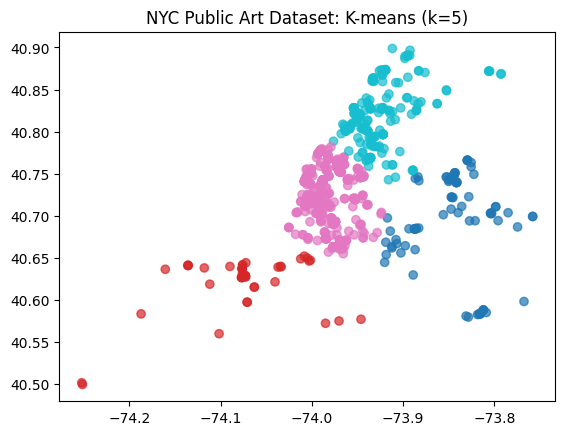

In [58]:
# K-means
plt.scatter(art_df["lng"], art_df["lat"], c=art_df["cluster_kmeans"], cmap="tab10", alpha=0.7)
plt.title("NYC Public Art Dataset: K-means (k=5)")
plt.show()

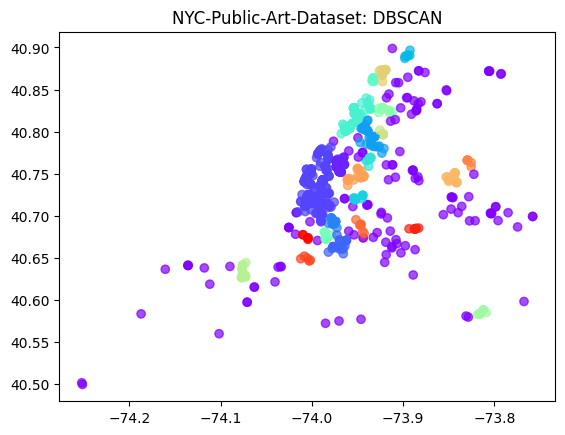

In [59]:
# DBSCAN
plt.scatter(art_df["lng"], art_df["lat"], c=art_df["cluster_dbscan"], cmap="rainbow", alpha=0.7)
plt.title("NYC-Public-Art-Dataset: DBSCAN")
plt.show()

## Part 4: Balanced Clusters Extension (Optional for Exemplary)



In [62]:
class KMeans_Extension:
    def __init__(self, k=5, max_iterations=100, balanced=False):
        """
        :param k: number of clusters
        :param max_iterations: max iterations for the algorithm
        :param balanced: if True, try to maintain balanced cluster sizes
        """
        self.k = k
        self.max_iterations = max_iterations
        self.balanced = balanced
        self.centroids = None

    def fit(self, X):
        """
        Fits the K-Means model to the data X using `k` clusters
        and up to `max_iterations` iterations. If self.balanced is True,
        tries to keep cluster sizes roughly equal.
        """
        np.random.seed(42)

        # Randomly select initial centroids from X
        initial_indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[initial_indices].copy()

        for _ in range(self.max_iterations):
            # Assign clusters
            if self.balanced:
                clusters = self._assign_clusters_balanced(X)
            else:
                clusters = self._assign_clusters_default(X)

            # Compute new centroids
            new_centroids = self._compute_centroids(X, clusters)

            # Check for convergence
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

        return clusters, self.centroids

    def _assign_clusters_default(self, X):
        distance_matrix = self._compute_distance_matrix(X, self.centroids)
        clusters = np.argmin(distance_matrix, axis=1)
        return clusters

    def _assign_clusters_balanced(self, X):
        """
        Balanced assignment heuristic:
        1. Compute distance to each centroid.
        2. Sort points by their best (minimum) distance to a centroid.
        3. Assign points in that order, respecting a max capacity per cluster.
        """
        n_samples = X.shape[0]
        capacity = n_samples // self.k  # integer division
        # if n_samples isn't divisible by k, a few clusters can hold 1 more.

        # 1) distance_matrix[i][j] = distance of X[i] to centroid j
        distance_matrix = self._compute_distance_matrix(X, self.centroids)

        # 2) for each point i, get the centroid preference order
        sorted_indices = np.argsort(distance_matrix, axis=1)

        # keep track of cluster assignments
        clusters = -1 * np.ones(n_samples, dtype=int)

        # keep track of how many points each cluster has
        cluster_counts = np.zeros(self.k, dtype=int)

        # sort all points by their best-dist, i.e. how sure they are of a “best centroid”
        best_dist = np.min(distance_matrix, axis=1)
        point_order = np.argsort(best_dist)

        for i in point_order:
            # go through the centroid preferences for point i
            for c_idx in sorted_indices[i]:
                # if cluster c_idx is under capacity, assign point i
                if cluster_counts[c_idx] < capacity:
                    clusters[i] = c_idx
                    cluster_counts[c_idx] += 1
                    break
            # if all clusters are at capacity, place point i in its single best centroid
            if clusters[i] == -1:
                # force it into best centroid
                c_idx = sorted_indices[i, 0]
                clusters[i] = c_idx
                cluster_counts[c_idx] += 1

        return clusters

    def _compute_centroids(self, X, clusters):
        """
        Compute new centroids by taking the mean of points assigned to each cluster.
        If no points assigned to a cluster, randomly re-initialize that centroid.
        """
        new_centroids = []
        for cluster_idx in range(self.k):
            points_in_cluster = X[clusters == cluster_idx]
            if len(points_in_cluster) > 0:
                new_centroids.append(points_in_cluster.mean(axis=0))
            else:
                new_centroids.append(X[np.random.choice(X.shape[0])])
        return np.array(new_centroids)

    def _compute_distance_matrix(self, X, centroids):
        """
        Compute Euclidean distance matrix of shape
        """
        n_samples = X.shape[0]
        distance_matrix = np.zeros((n_samples, self.k))
        for j, c in enumerate(centroids):
            dist_to_c = np.sqrt(np.sum((X - c) ** 2, axis=1))
            distance_matrix[:, j] = dist_to_c
        return distance_matrix


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SklearnKMeans

X, true_cluster_assignments = make_blobs(
    n_samples=700,
    centers=4,
    cluster_std=0.60,
    random_state=0
)
print(X.shape)
print(np.unique(true_cluster_assignments))

(700, 2)
[0 1 2 3]


In [64]:
#Balanced K-Means
my_kmeans_bal = KMeans_Extension(k=4, max_iterations=100, balanced=True)
pred_bal_clusters, bal_centroids = my_kmeans_bal.fit(X)


In [68]:
# Defauly K-Means (my implementation, balanced=False)
my_kmeans_van = KMeans_Extension(k=4, max_iterations=100, balanced=False)
pred_van_clusters, van_centroids = my_kmeans_van.fit(X)

In [69]:
# scikit-learn's K-Means
sk_kmeans = SklearnKMeans(n_clusters=4, max_iter=100, random_state=42, n_init=10)
sk_clusters = sk_kmeans.fit_predict(X)
sk_centroids = sk_kmeans.cluster_centers_

In [70]:
def plot_clusters(X, clusters, centroids, title):
    plt.scatter(X[:, 0], X[:, 1], c=clusters, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
    plt.title(title)
    plt.show()

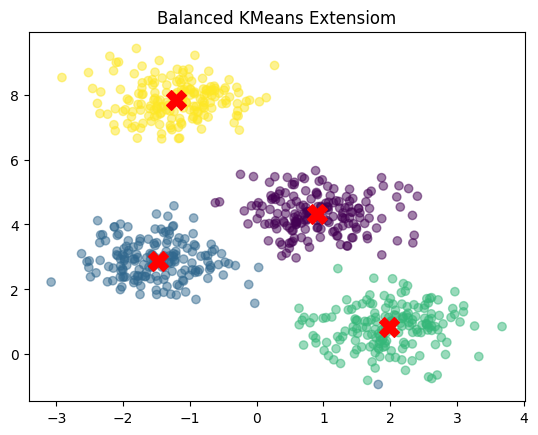

In [72]:
# Plot Balanced
plot_clusters(X, pred_bal_clusters, bal_centroids, "Balanced KMeans Extensiom")

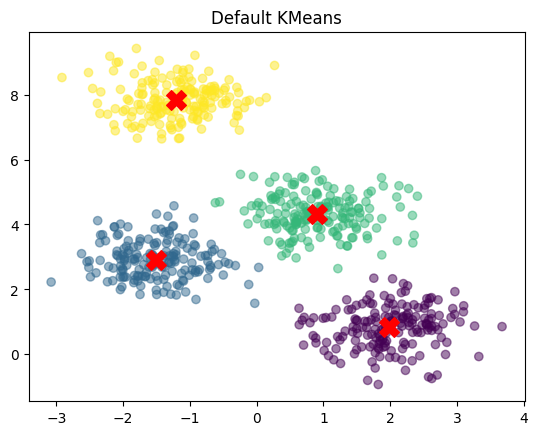

In [74]:
# Plot Default
plot_clusters(X, pred_van_clusters, van_centroids, "Default KMeans")

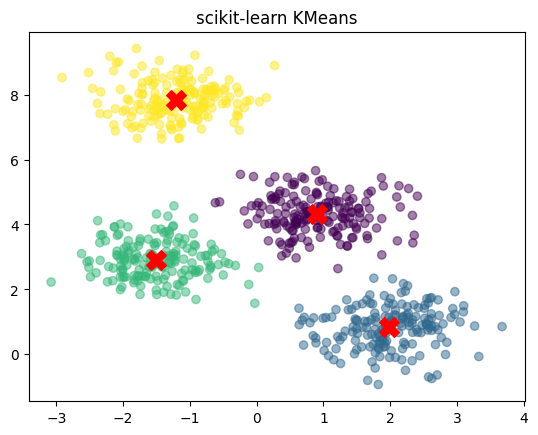

In [75]:
# Plot scikit-learn
plot_clusters(X, sk_clusters, sk_centroids, "scikit-learn KMeans")

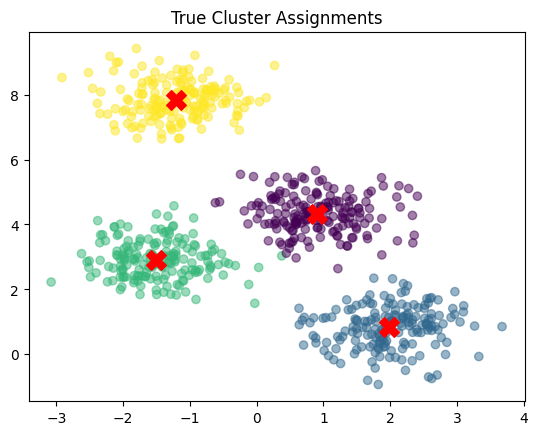

In [76]:
#'true' cluster assignments
plot_clusters(X, true_cluster_assignments, sk_centroids, "True Cluster Assignments")

In [77]:
# cluster counts for balanced approach
print("Balanced approach cluster counts:", np.bincount(pred_bal_clusters))
print("Vanilla approach cluster counts:", np.bincount(pred_van_clusters))
print("sklearn approach cluster counts:", np.bincount(sk_clusters))

Balanced approach cluster counts: [175 175 175 175]
Vanilla approach cluster counts: [175 174 176 175]
sklearn approach cluster counts: [176 175 174 175]
